In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from sklearn.ensemble import RandomForestRegressor
import pickle

from src.data.retrieve_data import get_msdFlow, get_usgs_data, get_mean_precip
from src.data.prepare_input_data import prepare_data_in
from src.models.var_importance import get_var_importances
from src.models.model_performance import performance_gage_simple_split
from src.models.model_validation import simple_split_validation 
from src.plots.plot_RII import get_cmap_and_norm
from src.plots.plot_var_importances import plot_var_importances
from src.plots.plot_time_series import plot_full_time_series
from src.plots.plot_model_performances import plot_model_performances
from src.models.explainers import get_explainers
from src.plots.plot_RII import plot_explainers, plot_explainers_with_time_series

from settings import param_file




c:\Users\pc\.conda\envs\cso_proj\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Model Params

In [2]:
n_trees       = param_file.params["model_params"]["n_estimators"]
max_samples   = param_file.params["model_params"]["max_samples"]
random_state  = param_file.params["model_params"]["random_state"]
max_features  = param_file.params["model_params"]["max_features"]
fraction_test = param_file.params["model_params"]["fraction_test"]
ndays_lag     = param_file.params["model_params"]["ndays_lag"]
mgd2cms = 0.043812636574074

### Prepare Data - Include Precip

In [3]:

# |--------------------------------------Read data --------------------------------------|
msd_flow     = get_msdFlow()
usgs_flow    = get_usgs_data()*0.646 # convert to MGD
path_precip2 = "./data/raw/precip_GHCN-daily_2019-2021_inches.csv"
precip       = pd.read_csv(path_precip2, index_col="DATE",parse_dates=True)["PRCP_in"]*254 # tenths of mm
precip.rename("Precip", inplace = True)
precip       = precip.to_frame()


# |------------------------------------Match data -------------------------------------|
# Get station names
usgs_names  = usgs_flow.columns
msd_names   = msd_flow.columns
precip_name = precip.columns

# match time series
full_Df = usgs_flow.join(precip).join(msd_flow).dropna().resample('D').asfreq().interpolate('linear')

# ------------------------------------Matched time series-------------------------------|

usgs_flow_match = full_Df[usgs_names]
msd_match       = full_Df[msd_names]
precip_match    = full_Df[precip_name]



### Get variable importances 

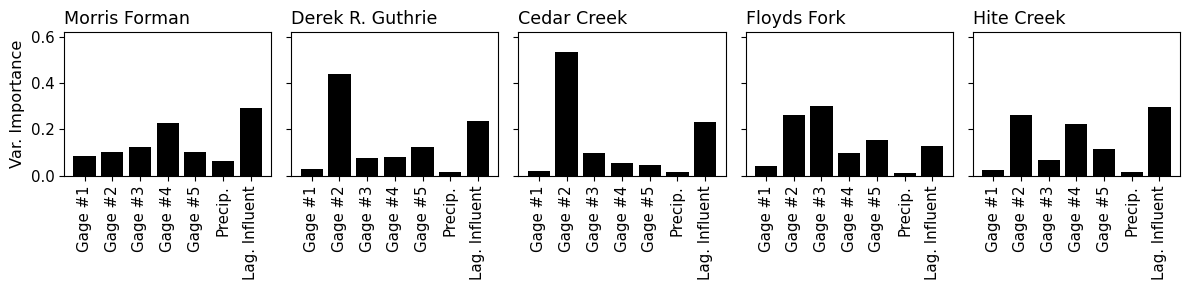

In [8]:
model         = RandomForestRegressor(n_estimators = n_trees, 
                                      max_samples  = max_samples, 
                                      random_state = 150
                                     )

importance_list = list()

for msd_name in msd_match.columns:

  var_importances, var_names = get_var_importances(model, 
                                                  msd_match[msd_name], 
                                                  usgs_flow_match[["03292500","03292555","03293000","03293530","03293510"]], 
                                                  precip_match, 
                                                  fraction_test = 1/3, 
                                                  Qusgs_lags = 0,
                                                  Qwwtp_lags  = 1
                                                  )
                                                  
  importance_list.append(var_importances)

plot_var_importances(importance_list, var_names, msd_match.columns)
# plt.savefig('./Results/Poster_Figs/fig_VI.png', bbox_inches='tight', dpi = 500)


### Time Series 

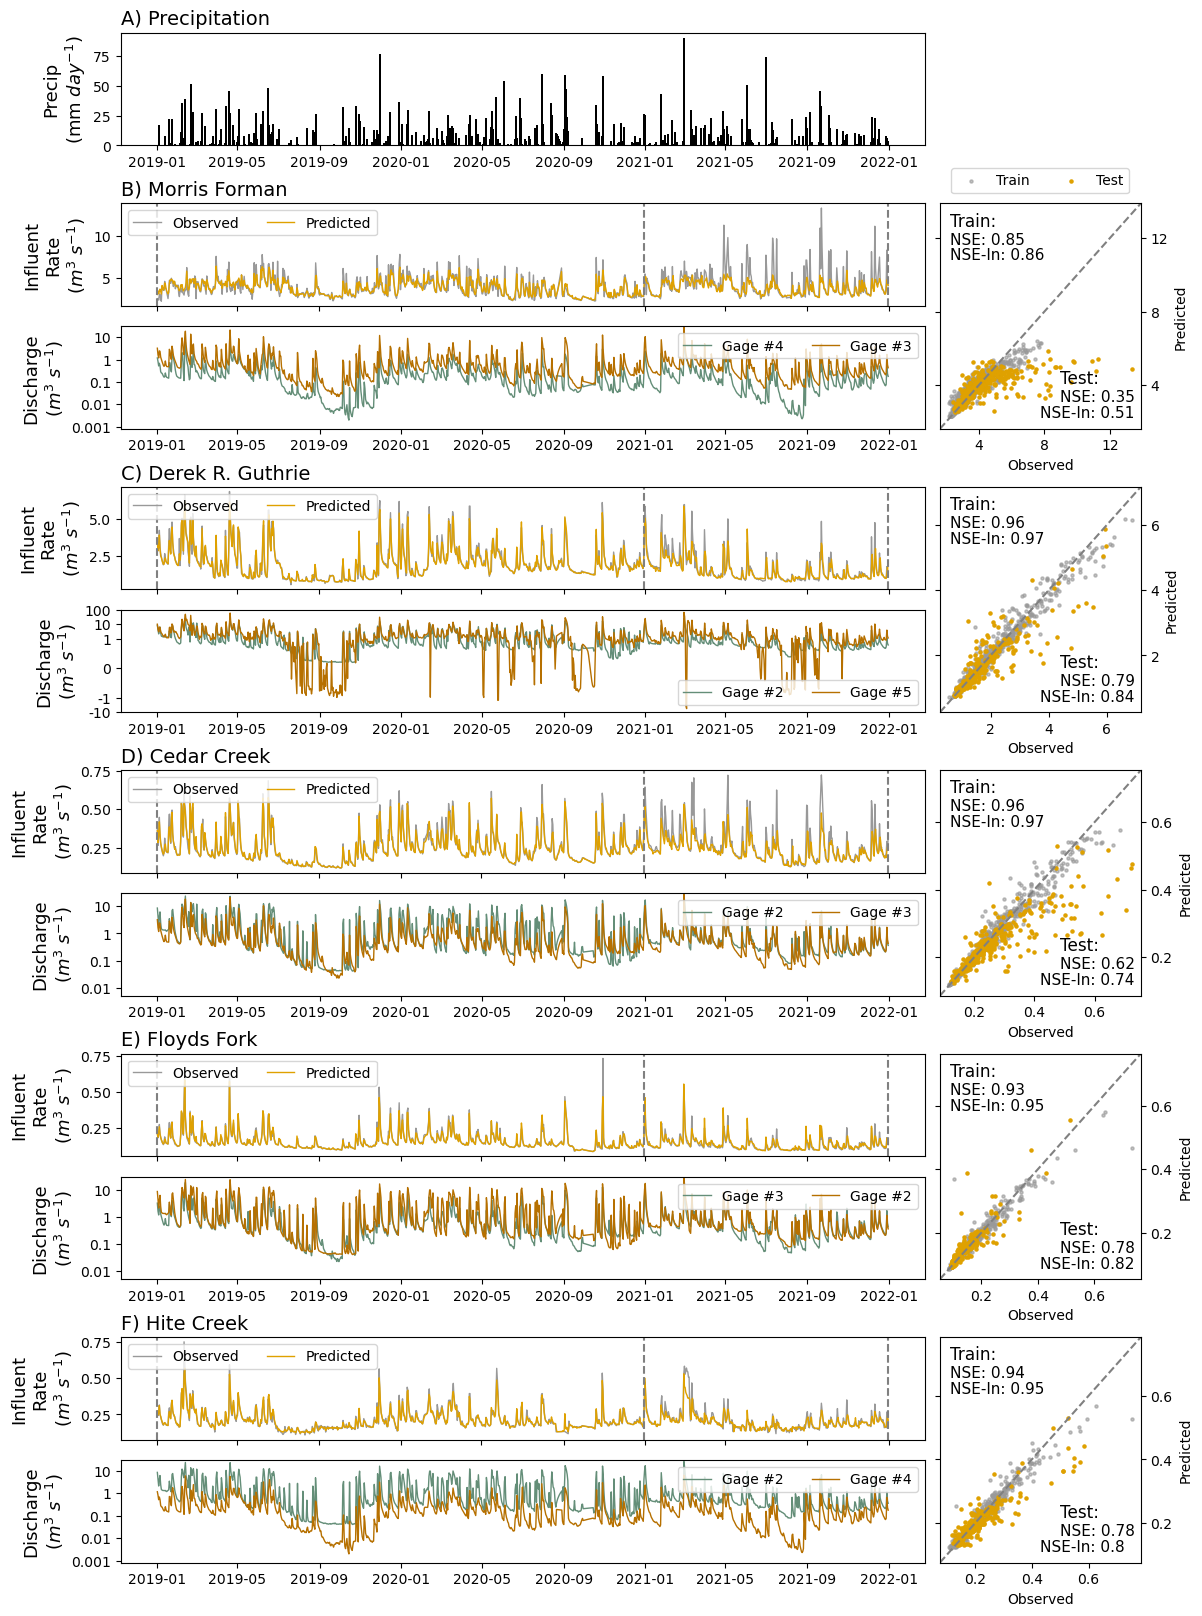

In [9]:
max_samples = 0.7
n_trees = 100
model         = RandomForestRegressor(n_estimators = n_trees, 
                                      max_samples  = max_samples, 
                                      random_state = random_state,
                                     )

gauge_list           = {'MFWQTC(MGD)' : ['03293530', '03293000'],
                        'DRGWQTC(MGD)': ['03292555', '03293510'],
                        'CCWQTC(MGD)' : ['03292555', '03293000'], 
                        'FFWQTP(MGD)' : ['03293000', '03292555'],
                        'HCWQTP(MGD)' : ['03292555', '03293530']
                        }

names_list, train_list, test_list = simple_split_validation(model,
                                                            usgs_flow_match*mgd2cms, 
                                                            msd_match*mgd2cms, 
                                                            gauge_list, 
                                                            n_test_frac = 1/3, 
                                                            Qusgs_lags = 0, 
                                                            Qwwtp_lags = 1, 
                                                            )


plot_full_time_series(precip_match, usgs_flow_match*mgd2cms, gauge_list, names_list, train_list, test_list)
# plt.savefig('./Results/Figs/fig2_V2.png', bbox_inches='tight', dpi = 300)

### Explainers

In [13]:

gauge_list           = {'MFWQTC(MGD)' : ['03293530', '03293000'],
                        'DRGWQTC(MGD)': ['03292555', '03293510'],
                        'CCWQTC(MGD)' : ['03292555', '03293000'], 
                        'FFWQTP(MGD)' : ['03293000', '03292555'],
                        'HCWQTP(MGD)' : ['03292555', '03293530']
                        }

names_list = msd_match.columns

# name = names_list[0]
n_lags = 1
# Pcolormesh parameters
qt_1_percentile = 0.5                   # percentile to define Reference lagged Q

ale_xpl_list   = list()
shap_xpl_list  = list()
col_names_list = list()
trainX_list    = list()
xv_list        = list()
yv_list        = list()
yhat_mesh_list = list()

for i, name in enumerate(names_list):
  model = RandomForestRegressor(n_estimators = 100, 
                                max_samples  = max_samples, 
                                random_state = 123
                               )

  no_lag_DF_filt  = usgs_flow_match[gauge_list[name]]
  lag_DF          = msd_match[name]
  
  data, col_names = prepare_data_in(no_lag_DF_filt, lag_DF, precip = None, Qusgs_lags = 0, Qwwtp_lags = 1)
  
  Qt_1   = lag_DF.quantile(qt_1_percentile) # Reference lagged Q
  # Qt_1   = None # Don't use lagged inflow
  
  baseQ1 = no_lag_DF_filt.quantile(0.05)[0]
  baseQ2 = no_lag_DF_filt.quantile(0.05)[1]
  ale_exp, shap_exp, trainX, yhat_mesh, xv, yv = get_explainers(data, col_names, model, Qt_1, baseQ1, baseQ2)
  
  ale_xpl_list.append(ale_exp)
  shap_xpl_list.append(shap_exp)
  col_names_list.append(col_names)
  trainX_list.append(trainX)
  xv_list.append(xv)
  yv_list.append(yv)
  yhat_mesh_list.append(yhat_mesh)


 99%|===================| 1089/1095 [01:11<00:00]        

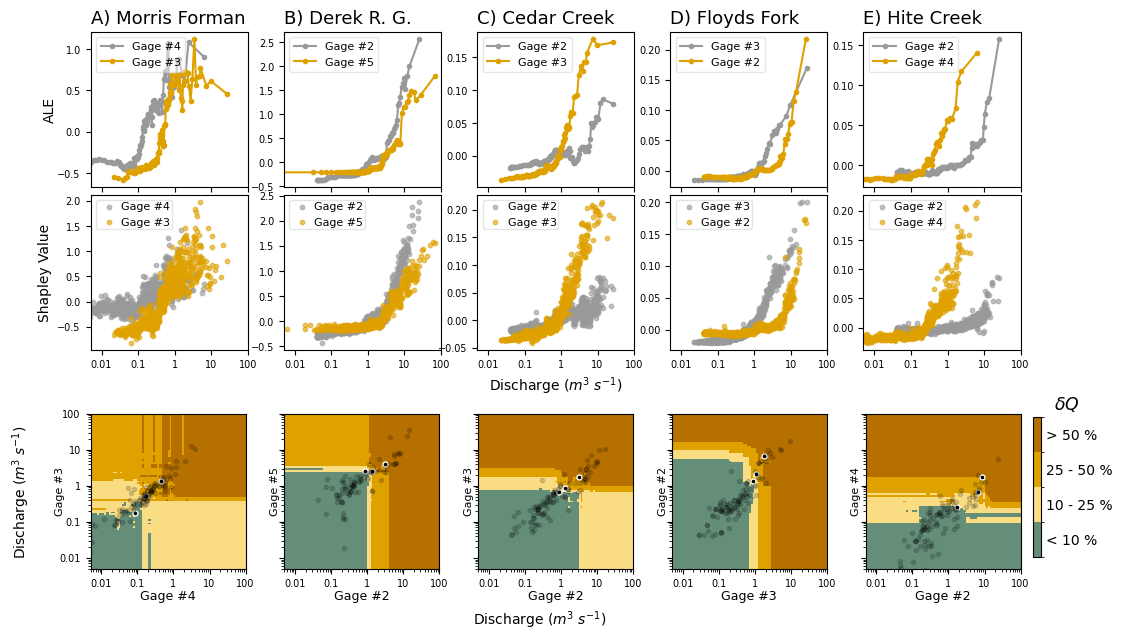

In [6]:
        
plot_explainers(**RII_input_vars)
plt.savefig('./Results/Figs/fig4_.png', bbox_inches='tight', dpi = 300)

#### 2021

In [4]:
random_state = 10
max_samples = 0.7
gauge_list           = {'MFWQTC(MGD)' : ['03293530', '03293000'],
                        'DRGWQTC(MGD)': ['03292555', '03293510'],
                        }

names_list = msd_match.columns[:2]

# name = names_list[0]
n_lags = 1
Qwwtp_lags = 1
# Pcolormesh parameters
qt_1_percentile = 0.5                   # percentile to define Reference lagged Q

ale_xpl_list   = list()
shap_xpl_list  = list()
col_names_list = list()
trainX_list    = list()
xv_list        = list()
yv_list        = list()
yhat_mesh_list = list()
models_list    = list()
obs_sim_ts_list = list()
OOB_scores      = list()
for i, name in enumerate(names_list):
  model = RandomForestRegressor(n_estimators = 100, 
                                max_samples  = max_samples, 
                                random_state = random_state,
                                oob_score=True
                               )

  no_lag_DF_filt  = usgs_flow_match[gauge_list[name]]["2021-03-25":]
  lag_DF          = msd_match[name]["2021-03-25":]
  
  data, col_names = prepare_data_in(no_lag_DF_filt, lag_DF, precip = None, Qusgs_lags = 0, Qwwtp_lags = Qwwtp_lags)
  
  Qt_1   = lag_DF.quantile(qt_1_percentile) # Reference lagged Q
  # Qt_1   = None
  baseQ1 = no_lag_DF_filt.quantile(0.05)[0]
  baseQ2 = no_lag_DF_filt.quantile(0.05)[1]
  ale_exp, shap_exp, trainX, yhat_mesh, xv, yv, model = get_explainers(data, col_names, model, Qt_1, baseQ1, baseQ2, return_model = True)
  
  ale_xpl_list.append(ale_exp)
  shap_xpl_list.append(shap_exp)
  col_names_list.append(col_names)
  trainX_list.append(trainX)
  xv_list.append(xv)
  yv_list.append(yv)
  yhat_mesh_list.append(yhat_mesh)


  # Generate DF for time series
  yhat = model.predict(trainX)
  df = pd.DataFrame(data = trainX, columns= col_names[:-1], index = no_lag_DF_filt.index[Qwwtp_lags:])
  df["simulated"] = yhat
  obs_sim_ts_list.append(df.join(msd_match[name])[["simulated",msd_match[name].name]])
  OOB_scores.append(model.oob_score_)


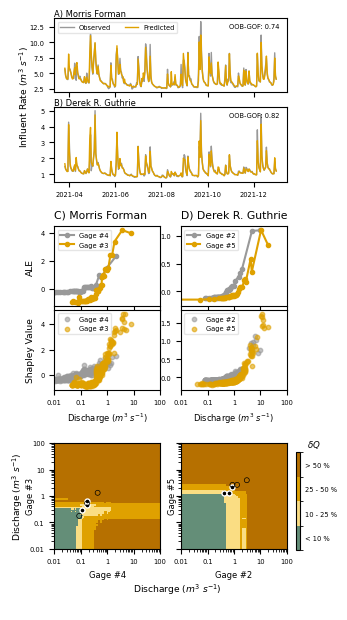

In [10]:

plot_explainers_with_time_series(names_list, 
                                ale_xpl_list, 
                                shap_xpl_list, 
                                col_names_list, 
                                trainX_list, 
                                xv_list, 
                                yv_list, 
                                yhat_mesh_list,
                                obs_sim_ts_list,
                                OOB_scores
                                )
plt.savefig('./Results/Figs/RII_2.png', bbox_inches='tight', dpi = 300)